CDO Tranche Pricing
-------------------

The par spread $S$ of a CDS tranche is given by
$$S = \frac{\text{Protection Leg PV}}{\text{RPV01}},$$

where
$$\begin{aligned}
\text{RPV01} &= \sum_{i} \Delta_i Z(t_i) \frac{Q(t_{i-1},K_1,K_2) + Q(t_i, K_1, K_2)}{2} \\
\text{Protection Leg PV} &= \int_{0}^{T} Z(t) (-dQ(t,K_1,K_2))
\end{aligned}$$

Here, 

* $K_1, K_2, T$ is the tranche starting level, final level, and maturity, respectively.
* $Z(t)$ is the discount factor curve.
* $Q(t,K_1,K_2)$ is the tranche survival curve: $Q(t,K_1,K_2)= 1 - \frac{f(t, K_2) - f(t, K_1)}{K_2 - K_1}$
* $t_i$ is the time of the $i^{th}$ premium payment. And $\Delta_i$ is the time-fraction of the $i^{th}$
  interval, using the Act365 DCF.
 
  
And $f(t,K) = E[ \min (L(t),K)]$ is model-dependent.

With the exception for the formula of $Q$, the CDO tranche pricing formula is identical to
the CDS pricing formula with $R=0$. So we first define a class for calculating CDS's.

In [1]:
from datetime import timedelta
class CDS(object):
    """A generic CDS class. Can also be used for CDO tranches.
    
    Attributes:
        today (datetime.date): The present date.
        maturity (datetime.date): The maturity of the CDO.
        remaining_payments (list): A list of datetime.date objects indicating 
            the remaining payment dates for the premium leg.
        R (float): The recovery fraction (0 to 1).
        Z (callable function): A function Z(t) that outputs the discount factor
            Z(t) for a given time t (datetime.date object). Input and output are
            both positive floats.
        Q (callable function): A function Q(t) that takes in a single
            datetime.date perameter and returns a float representing the tranche
            survival probability. This function should be well-defined for all 
            dates between `today` and `maturity`.
    """
    def __init__(self, today, maturity, remaining_payments, R, Z, Q):
        self.today = today
        self.maturity = maturity
        self.remaining_payments = remaining_payments
        self.R = R
        self.Z = Z
        self.Q = Q
    def rpv01(self):
        """Returns the value of the tranche premium leg for unit notional.
        """
        days = [self.today] + self.remaining_payments
        print(days)
        nodes = [(day - self.today).days / 365 for day in days]
        #qvals = [self.Q(day) for day in days]
        qvals = self.Q
        total = 0
        for i in range(1, len(days)):
            delta = nodes[i] - nodes[i - 1]
            total += delta * self.Z(days[i]) * (qvals[i] + qvals[i - 1])
        return total / 2
    def protectionLegPV(self, N = 200):
        """Returns the value of the protection leg for unit notional.
        
        Arguments:
            N (int, optional): The number of nodes for calculating the integral.
        """
        delta = (self.maturity - self.today).days / N
        days = [today + timedelta(days = delta) * n for n in range(N + 1)]
        #print(days)
        #qvals = [self.Q(day) for day in days]
        qvals = self.Q
        values = [Z(days[i]) * (qvals[i - 1] - qvals[i])
                  for i in range(1, len(days))]
        return (1 - self.R) * sum(values)
    def parSpread(self, N = 200):
        """ Returns the par spread.
        
        Arguments:
            N (int, optional): The number of nodes for calculating the 
                protection leg integral.
        """
        return self.protectionLegPV(N) / self.rpv01()

Large Homogenous Portfolio (LHP) Model
--------------------------------------

The LHP tranche pricing model is given by the following equations:
$$\begin{aligned}
E[\min (L(T), K)] &= (1-R) \Phi_{2}(C(T), -A(K), - \beta) + K \Phi(A(K)) \\
A(K) &= \frac{1}{\beta} \left( C(T) - \sqrt{1 - \beta^{2}} \Phi^{-1} \left( \frac{K}{1-R} \right) \right) \\
C(T) &= \Phi^{-1} (1 - Q(T))
\end{aligned}$$

Here:
* $\Phi_{2}$ is the cdf of the bivariate normal distribution. The third perameter being correlation.
* $\beta^{2}$ the correlation
* $R$ is the recovery rate.
* $Q(T)$ is the survival curve

In [10]:
from scipy.stats import norm, mvn #normal and bivariate normal
from numpy       import sqrt

def Q_lhp(t, K1, K2, R, beta, Q):
    """Calculates the Tranche survival curve for the LHP model.
    
    Args:
        T (datetime.date): Should be given in "days" (no hours, minutes, etc.)
        K1 (float): The starting value of the tranche. Its value should be 
            between 0 & 1.
        K2 (float): The final value of the tranche. 
        beta (float): Correlation perameter. Its value should be between 0 and 1.
        R (float): Recovery rate. Usually between 0 and 1.
        Q (callable function): A function Q that takes in a dateime.date and
            outputs a float from 0 to 1. It is assumed that Q(0) = 1 and Q is 
            decreasing. Represents survival curve of each credit.
    """
    if Q(t) == 1:
        return 1 # prevents infinity
    def emin(K):
    # Calculates E[min(L(T), K)] in LHP model
        print(Q(t))
        C = norm.ppf(1 - Q(t))
        A = (1 / beta) * (C - sqrt(1 - beta * beta) * norm.ppf(K / (1 - R)))
        return (1 - R) * mvn.mvndst(upper = [C, -1 * A],
                                    lower = [0,0],
                                    infin = [0,0], # set lower bounds = -infty
                                    correl =  -1 * beta)[1] + K * norm.cdf(A)
    return 1 - (emin(K2) - emin(K1)) / (K2 - K1)

Gaussian Heterogenous Model
---------------------------

The tranche survival curve is given by 

$$\begin{aligned}
Q_{\text{Gauss}} (t, K_1, K_2) & = 1 - \frac{1}{K_2 - K_1} \int_{- \infty}^{+ \infty} \phi (z) f(z) dz \\
f(z) &= \sigma \phi \left(\frac{\mu - K_1}{\sigma} \right) + (\mu - K_1) \Phi \left( \frac{\mu - K_1}{\sigma} \right) - (\mu - K_2) \Phi \left( \frac{\mu - K_2}{\sigma} \right) - \sigma \phi \left( \frac{\mu - K2}{\sigma} \right) \\
\mu &= \frac{1}{N} \sum_{i=1}^{N} p_{i}(t,z) F_i (1 - R_i) \\
\sigma^{2} &= \frac{1}{N^2} \sum_{i=1}^{N} p_i (t,z) (1 - p_i (t,z)) F_i^2 (1-R_i)^{2} \\
p_{i}(t,z) &= \Phi \left( \frac{C_i (t) - \beta_i z}{\sqrt{1 - \beta_i^2}}\right) \\
C_{i} (t) &= \Phi^{-1} (1 -Q_i (t))
\end{aligned}$$

Here:

* $K_1, K_2$ are the boundaries of the tranche (they are between 0 and 1).
* $N$ is the number of credits
* $F_i$ is the fractional face value of the $i$th credit.
* $R_i$ is the recovery rate of the $i$th credit.
* $\beta_{i}$ is the $i$th correlation perameter
* $Q_i$ is the survival curve of the $i$th credit.

Unlike the LHP model, this is heterogenous in that each credit has distinct values of $ R_i, \beta_i, Q_i$. Moreover, the values of $F_i$ becomes relevant.

In [3]:
from scipy.integrate import quad
def Q_gauss(t, K1, K2, Fs, Rs, betas, Qs):
    """ Calculate the tranche survival probability in the Gaussian heterogenous model.
    
    Arguments:
        t (float): Time. Positive.
        K1 (float): Starting tranche value. Between 0 and 1.
        K2 (float): Ending tranche value. Between 0 and 1.
        Fs (list): List of fractional face values for each credit. Each entry must be
            between 0 and 1.
        Rs (list): List of recovery rates for each credit. Each entry must be between
            0 and 1.
        betas (list): Correlation perameters for each credit. Each entry must be between
            0 and 1.
        Qs (list): Survival curves for each credit. Each entry must be a callable function
            that takes in a datetime.date argument and returns a number from 0 to 1.
    """
    Cs = [norm.ppf(1 - q(t)) for q in Qs]
    N = len(Fs) 
    def f(z):
        ps = [norm.cdf((C - beta * z) / sqrt(1 - beta * beta)) for C, beta in zip(Cs, betas)]
        mu = 1 / N * sum([p * F * (1 - R) for p, F, R in zip(ps, Fs, Rs)])
        sigma_squared = 1 / N / N * sum([p * (1 - p) * F ** 2 * (1 - R) ** 2 for p, F, R in zip(ps, Fs, Rs)])
        sigma = sqrt(sigma_squared)
        return (sigma * norm.pdf((mu - K1) / sigma)
                - sigma * norm.pdf((mu - K2) / sigma) 
                + (mu - K1) * norm.cdf((mu - K1) / sigma) 
                - (mu - K2) * norm.cdf((mu - K2) / sigma))
    integral = quad(lambda z: f(z) * norm.pdf(z), -10, 10)[0]
    return 1 - integral / (K2 - K1)

Adjusted Binomial Model
-----------------------

The adjusted binomial model is given as 

$$\begin{aligned}
E[min(L(T),K)] &= \sum_{k=0}^{N} h(k) \min (Lk, K) \\
h(k) &= \int_{- \infty}^{\infty} \phi (z) g(k) dz \\
g(k) &= \alpha f(k) \text{ for } k \neq l,u \\
g(l) &= f(l) + (1 - \alpha)(u - m) \\
g(u) &= f(u) - (1 - \alpha)(l - m) \\
l &= \text{floor} (m) \\
m &= p N \\
u &= l + 1 \\
p &= \frac{1}{N} \sum_{i=1}^N \frac{(1 - R_i)F_i}{L} p_i \\
\alpha &= \frac{v_E N + (u - m)^2 -((l -m)^2 - (u -m)^2)(u -m)}
{v_A N + (u - m)^2 -((l -m)^2 - (u -m)^2)(u -m)} \\
v_E &= \frac{1}{N^2} \sum_{i=1}^{N} \left( \frac{(1-R_i)F_i}{L}\right)^2 p_i(1 - p_i) \\
v_A &= \frac{p(1-p)}{N} \\
f(k) &= \frac{N!}{(N - k)! k!} p^k (1 - p)^{N - k} \\
L &= \frac{1}{N} \sum_{i=1}^{N} (1 - R_i) F_i
\end{aligned}$$

In [4]:
def Q_adjbinom(t, K1, K2, Fs, Rs, betas, Qs):
    if Qs[0](t) == 1:
        return 1.0 # initial value -- avoids weird nan return
    N = len(Fs)
    Cs = [norm.ppf(1 - Q(t)) for Q in Qs]
    L = sum([(1 - R) * F for R, F in zip(Rs, Fs)]) / N
    def choose(n, k): # Calculates binomial coeffecient: n choose k.
        if k == 0 or k == n:
            return 1
        return choose(n - 1, k - 1) + choose(n - 1, k)
    def g(k,z):
        ps = [norm.cdf((C - beta * z) / sqrt(1 - beta * beta)) for C, beta in zip(Cs, betas)]
        p_avg = sum([(1 - R) * F / L * p for R, F, p in zip(Rs, Fs, ps)]) / N
        f = lambda k: choose(N, k) * p_avg ** k * (1 - p_avg) ** (N - k)
        vA = p_avg * (1 - p_avg) / N
        vE = 1 / N / N * sum([((1 - R) * F / L) ** 2 * p * (1 - p) for R, F, p in zip(Rs, Fs, ps)])
        m = p_avg * N
        l = int(m)
        u = l + 1
        o = (u - m) ** 2 + ((l - m) ** 2 - (u - m) ** 2) * (u - m)
        alpha = (vE * N + o) / (vA * N + o)
        if k == l:
            return f(l) + (1 - alpha) * (u - m)
        if k == u:
            return f(u) - (1 - alpha) * (l - m)
        return alpha * f(k)
    I = lambda k: quad(lambda z: norm.pdf(z) * g(k, z), -10, 10)[0]
    emin = lambda K: sum([I(k) * min(L * k, K) for k in range(0, N + 1)])
    return 1 - (emin(K2) - emin(K1)) / (K2 - K1)

Example
-------

In [6]:
from numpy import exp
from datetime import date, timedelta
K1 = 0.03
K2 = 0.07
Fs = [0.3, 0.8]
Rs = [0.40, 0.60]
def expdecay(today, rate):
    return lambda t: exp(-1 * (t - today).days / 365 * rate)
today = date(2012,1, 1)
Qs = [expdecay(today, 0.0120), expdecay(today, 0.0160)]
betas = [0.30, 0.40]
tvalues = [today + timedelta(days = 30) * n for n in range(37)] #3 years
# LHP perameters average the other perameters
R = 0.50
Q = expdecay(today, 0.0140)
beta = 0.35

In [11]:
# Takes FOREVER
lhpcurve = [Q_lhp(t, K1, K2, R, beta, Q) for t in tvalues]
adjointbinomialcurve = [Q_adjbinom(t, K1, K2, Fs, Rs, betas, Qs) for t in tvalues]
gaussiancurve = [Q_gauss(t, K1, K2, Fs, Rs, betas, Qs) for t in tvalues]

0.998849976853
0.998849976853
0.997701276258
0.997701276258
0.996553896696
0.996553896696
0.995407836647
0.995407836647
0.994263094594
0.994263094594
0.993119669021
0.993119669021
0.991977558413
0.991977558413
0.990836761259
0.990836761259
0.989697276048
0.989697276048
0.988559101272
0.988559101272
0.987422235423
0.987422235423
0.986286676996
0.986286676996
0.985152424487
0.985152424487
0.984019476395
0.984019476395
0.98288783122
0.98288783122
0.981757487463
0.981757487463
0.980628443627
0.980628443627
0.979500698218
0.979500698218
0.978374249742
0.978374249742
0.977249096708
0.977249096708
0.976125237626
0.976125237626
0.975002671008
0.975002671008
0.973881395367
0.973881395367
0.972761409219
0.972761409219
0.971642711082
0.971642711082
0.970525299473
0.970525299473
0.969409172914
0.969409172914
0.968294329925
0.968294329925
0.967180769032
0.967180769032
0.96606848876
0.96606848876
0.964957487636
0.964957487636
0.963847764189
0.963847764189
0.96273931695
0.96273931695
0.96163214445
0.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in double_scalars


In [9]:
print(lhpcurve)

[1, 0.99999965994584639, 0.99999403008865395, 0.9999706601224525, 0.99991294341174453, 0.99980281743998867, 0.99962227890088384, 0.99935421949909686, 0.99898287173271905, 0.99849402485884109, 0.9978751030782792, 0.99711516071979356, 0.9962048279541551, 0.99513622798540191, 0.993902878981757, 0.99249958919651116, 0.99092235065545786, 0.98916823479392924, 0.98723529211910255, 0.98512245710987867, 0.98282945899499463, 0.98035673867244555, 0.9777053717860773, 0.97487699781614656, 0.97187375494151729, 0.96869822037277209, 0.96535335582480464, 0.96184245778543576, 0.95816911223698287, 0.9543371534962739, 0.95035062685223937, 0.94621375469695057, 0.94193090586429051, 0.93750656790941256, 0.93294532208106518, 0.92825182075731805, 0.92343076713293815]


<function matplotlib.pyplot.show>

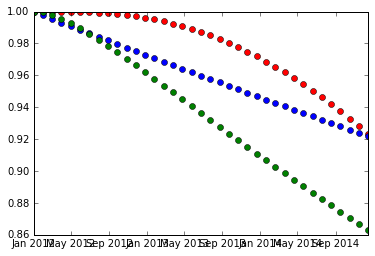

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tvalues, lhpcurve, 'ro', #red
         tvalues, adjointbinomialcurve, 'bo', #blue
         tvalues, gaussiancurve, 'go' #green
         )
plt.show

In [39]:
## Test Spreads
maturity = tvalues
remaining_payments = tvalues
Z = expdecay(today, 0.0140)

#print(lhpcurve[1])
N = len(lhpcurve)
print(N)
#print(today)
#print(maturity)
CDS1 = CDS(today=today, maturity = maturity, remaining_payments = remaining_payments, R = R, Z = Z, Q = lhpcurve)

CDS1.parSpread(N=N)

37


TypeError: unsupported operand type(s) for -: 'list' and 'datetime.date'